In [1]:
from sparc import load_model
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

color_code = {"UL":matplotlib.colors.to_rgb("#EE3A5B"),
              "LL":matplotlib.colors.to_rgb("#FFD155"),
              "LI":matplotlib.colors.to_rgb("#959595"),
              "TT":matplotlib.colors.to_rgb("#43B962"),
              "TB":matplotlib.colors.to_rgb("#C44B9F"),
              "TD":matplotlib.colors.to_rgb("#0093B7"),
              "Loudness":matplotlib.colors.to_rgb("#FB754D"),
              "Pitch":matplotlib.colors.to_rgb("#FB754D"),}

def plot_art(ax, art, gap=5, skip_y=False,color=None,alpha=1.0, lw=2):
    yticks=[]
    ytick_labels=[]
    labels = ["UL","LL", "LI", "TT", "TB", "TD"]
    chidxs = []
    EMA_channel_label = ['TDX','TDY','TBX','TBY','TTX','TTY','LIX','LIY','ULX','ULY','LLX','LLY']
    channel_label = EMA_channel_label
    for l in labels:
        chidxs.append(EMA_channel_label.index(l+"X"))
        chidxs.append(EMA_channel_label.index(l+"Y"))


    for i,ch_i in enumerate(chidxs):
        ch_label = channel_label[ch_i]
        ytick_labels.append(ch_label)
        if ch_i < 12:
            art_name= ch_label[:2]
            if color is None:
                color = color_code[art_name]
            ax.plot(art[:,ch_i]-gap*i,color=color,alpha=alpha,lw=lw)
        else:
            art_name= ch_label
            if color is None:
                color = color_code[art_name]
            ax.plot(art[:,ch_i]-gap*i,color=color,alpha=alpha,lw=lw)
        yticks.append(-gap*i)
    if skip_y:
        ytick_labels = [""]*len(ytick_labels)

    ax.set_yticks(yticks,ytick_labels,fontsize=15)

    xticks= np.arange(0,len(art),50)
    xtick_labels= [f"{int(x*20/1000)}" for x in xticks]
    ax.set_xticks(xticks, xtick_labels,fontsize=15)
    ax.set_xlabel("Time (s)", fontsize=15)
    ax.set_xlim(0,len(art))
    return yticks

/home/cheoljun/anaconda3/envs/asp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
coder = load_model("en", device= "cpu")

/home/cheoljun/anaconda3/envs/asp/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


# Resynthesis

In [3]:
wav_file  = '../sample_audio/sample1.wav'

In [4]:
# Inversion
# EMA channel_label = ['TDX','TDY','TBX','TBY','TTX','TTY','LIX','LIY','ULX','ULY','LLX','LLY']
code = coder.encode(wav_file)

/home/cheoljun/anaconda3/envs/asp/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [5]:
#shapes
for name, values in code.items():
    print(f"{name}: {values.shape}")

ema: (475, 12)
loudness: (477, 1)
pitch: (476, 1)
periodicity: (476, 1)
pitch_stats: (2,)
spk_emb: (64,)
ft_len: ()


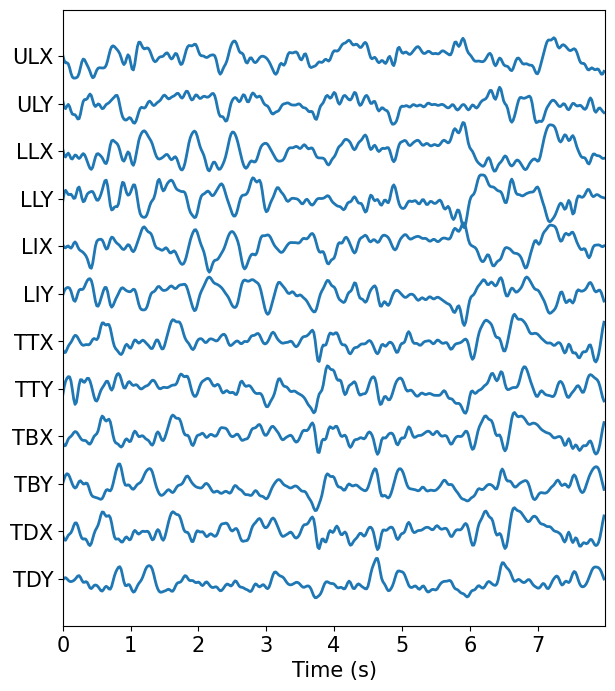

In [6]:
fig,ax = plt.subplots(1,1, figsize=(7,8))
plot_art(ax, code['ema'][:400], color='C0', gap=6, alpha=1, lw=2)
plt.show()

In [7]:
# Synthesis
wav = coder.decode(**code)

In [8]:
# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

In [9]:
#sf.write('../sample_audio/aave_sample-enhanced-v2_resynth.wav', wav, 16000)
sf.write('../sample_audio/ppa_resynth.wav', wav, 16000)

In [10]:
!cp /home/cheoljun/ppgs/segment5.wav ../sample_audio/ppa.wav

In [11]:
# ground truth reference
wavt,tsr = sf.read(wav_file)
ipd.display(ipd.Audio(wavt, rate=tsr))

# Voice Conversion

In [12]:
src_wav_file = "../sample_audio/sample1.wav"
trg_wav_file = "../sample_audio/sample2.wav"

In [13]:
converted_wav = coder.convert(src_wav_file, trg_wav_file)

/home/cheoljun/anaconda3/envs/asp/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [14]:
# converted
ipd.display(ipd.Audio(converted_wav, rate=coder.sr))

In [15]:
src_code = coder.encode(src_wav_file)

In [16]:
converted_code = coder.encode(converted_wav)

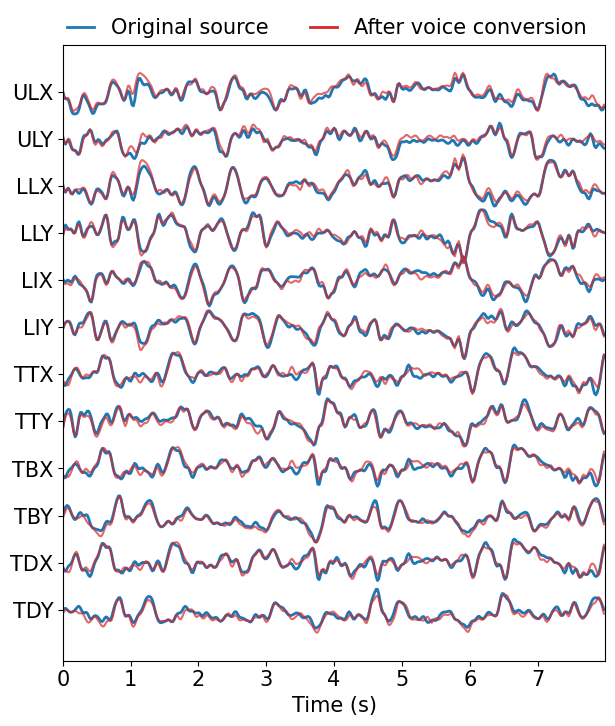

In [17]:
# Articulatory traces remain consistent after voice conversion.
fig,ax = plt.subplots(1,1, figsize=(7,8))
plot_art(ax, src_code['ema'][:400], color='C0', gap=6, alpha=1, lw=2)
plot_art(ax, converted_code['ema'][:400], color='C3', gap= 6, alpha=0.7, lw=1.5)
ax.plot([],[],label="Original source", color='C0', lw=2)
ax.plot([],[],label="After voice conversion", color='C3', lw=2,)
ax.legend(fontsize=15, handlelength=1.3,loc='lower right',bbox_to_anchor=(1.0,0.98), ncol=2, frameon=False)
plt.show()

In [18]:
# source audio
src_wav,sr = sf.read(src_wav_file)
ipd.display(ipd.Audio(src_wav, rate=sr))

In [19]:
# target audio
trg_wav,sr = sf.read(trg_wav_file)
ipd.display(ipd.Audio(trg_wav, rate=sr))

# Unseen Language

In [20]:
wav_file = "../sample_audio/italian.wav"

In [21]:
code = coder.encode(wav_file)

/home/cheoljun/anaconda3/envs/asp/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [22]:
wav = coder.decode(**code)

In [23]:
# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

In [24]:
# ground truth reference
wavt,tsr = sf.read(wav_file)
ipd.display(ipd.Audio(wavt, rate=tsr))